## Testing Clustering Methods


### Load the requirements

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for creating the x matrix to train
import sklearn
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom

In [2]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/waom10extend_grd.nc')

### Create the dataframe

In [3]:
# read the file and add the density values from aabw_neutral_densities.txt
with open("/scratch/project_2000789/muramarg/SOM/meeting_1017/df_allpts.txt","r") as g:
    inp = g.readlines()
g.close()
# read from the text file to make things faster
length_ratio1 = np.array([inp[0].split(',')[:-1]]).astype(float)
depth_means1 = np.array([inp[1].split(',')[:-1]]).astype(float)
depth_std1 = np.array([inp[2].split(',')[:-1]]).astype(float)
dt1 = np.array([inp[3].split(',')[:-1]]).astype(float)
dsalt1 = np.array([inp[4].split(',')[:-1]]).astype(float)
ddens1 = np.array([inp[7].split(',')[:-1]]).astype(float)
shelf_time1 = np.array([inp[6].split(',')[:-1]]).astype(float)

# create the dataframe
df = pd.DataFrame()
df["net distance:total distance"] = length_ratio1[0]
df["mean depth"] = depth_means1[0]
df["std depth"] = depth_std1[0]
df["dT"] = dt1[0]
df["d salt"] = dsalt1[0]
df["d density"] = ddens1[0]
df["time to shelf"] = shelf_time1[0]
df.head()

,net distance:total distance,mean depth,std depth,dT,d salt,d density,time to shelf
0,0.073205,358.836655,152.250534,-1.407402,0.087379,0.340220,259.031250
1,0.033335,586.706361,444.646362,-0.743235,0.218391,1.107802,152.906250
2,0.106888,280.551893,134.662430,-2.710640,0.172638,0.426925,149.083333
3,0.262303,421.582263,244.931870,-4.369052,0.347824,0.682872,257.677083
4,0.156761,309.248186,149.216553,-2.306775,0.204514,0.389524,466.343750


In [4]:
df = df.dropna()

In [5]:
x = df.iloc[:,:].values
#y = df.iloc[:,-1].values
sc = sklearn.preprocessing.MinMaxScaler(feature_range = (0,1))
x = sc.fit_transform(x)

### How are we storing the success rates of the various processes?

### Add the SOM

### SciPy Proximity Functions

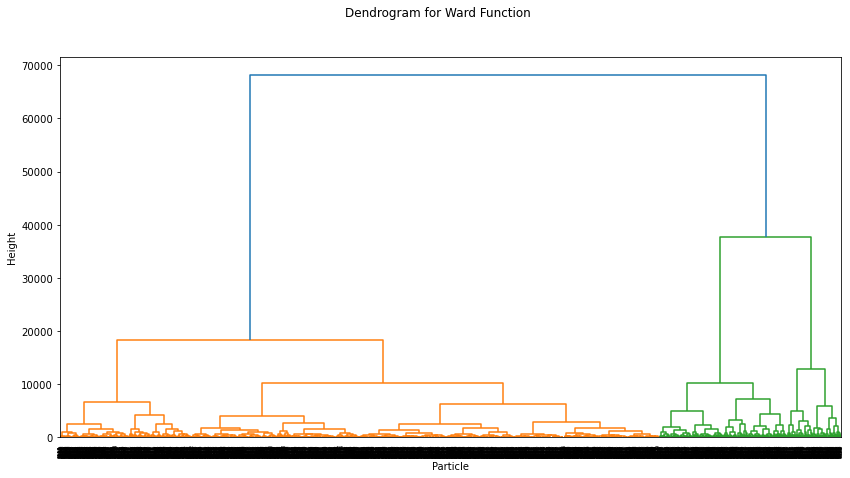

In [6]:
# Plot the dendrogram for the Ward proximity measure
index_names = list(df.index)

z = linkage(df,method='ward')
plt.figure(figsize = (14,7))
plt.suptitle('Dendrogram for Ward Function')
plt.xlabel('Particle')
plt.ylabel('Height')

dendrogramward = dendrogram(Z=z,labels=index_names,get_leaves=True)
plt.show()

In [7]:
# set the number of clusters and get the names
numclust = 6
fl = fcluster(z,numclust,criterion='maxclust')

# new dataframe
df_clst = pd.DataFrame()
df_clst['index']  = index_names
df_clst['clust_label']  = fl

# get the clusters from fcluster to choose centroids
centroids_idx = np.array([])
for i in range(6):
    # print the values in each group
    elements = df_clst[df_clst['clust_label']==i+1]['index'].tolist()  
    size = len(elements)
    #print('\n Cluster {}: N = {}  {}'.format(i+1, size, elements))
    
    # get a random number from elements as a centroid
    centroids_idx = np.append(centroids_idx, random.choice(elements))
print(centroids_idx)

[1883.   10.  476. 2020. 2511. 2198.]


### Find clusters based on k-means

In [8]:
# choose the centroids based on the smallest values from the particles
# we will choose the centroids at random from the 6 groups
# get the initial centroids
index_names = list(df.index)
c0 = df.iloc[index_names.index(centroids_idx[0])]
c1 = df.iloc[index_names.index(centroids_idx[1])]
c2 = df.iloc[index_names.index(centroids_idx[2])]
c3 = df.iloc[index_names.index(centroids_idx[3])]
c4 = df.iloc[index_names.index(centroids_idx[4])]
c5 = df.iloc[index_names.index(centroids_idx[5])]

centroids = np.array([c0,c1,c2,c3,c4,c5])
centroids

array([[ 5.39370663e-01,  3.93561739e+02,  1.66232468e+02,
        -2.94724071e+00,  5.36098480e-01,  7.64182743e-01,
         9.82812500e+01],
       [ 9.52936834e-02,  4.14098099e+02,  3.08670929e+02,
        -1.28890851e+00,  5.78369141e-01,  9.81614423e-01,
         4.48083333e+02],
       [ 1.28857226e-01,  1.79291313e+02,  2.00334229e+02,
        -2.01471184e+00,  5.65250397e-01,  8.47118982e-01,
         5.31468750e+02],
       [ 6.49376371e-02,  6.02409790e+02,  6.21397522e+02,
         1.16007775e+00,  1.63097382e-01,  7.02933238e-01,
         2.07489583e+02],
       [ 3.45757326e-01,  3.49691828e+03,  1.15648035e+03,
         1.60568658e+00,  1.09565735e-01,  2.01822771e+00,
         5.14791667e+01],
       [ 2.82069357e-01,  2.09498784e+03,  1.83202515e+03,
         1.58171540e+00,  1.33331299e-01,  2.11755579e+00,
         2.55218750e+02]])

In [9]:
# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=6,init=centroids,n_init=1,random_state=23).fit(df)
centroids = kmeans.cluster_centers_
assignment = kmeans.fit_predict(df,centroids)

# get the cluster for each state
zeroes=[x for x,y in enumerate(assignment) if y == 0]
ones=[x for x,y in enumerate(assignment) if y == 1]
twos=[x for x,y in enumerate(assignment) if y == 2]
threes=[x for x,y in enumerate(assignment) if y == 3]
fours=[x for x,y in enumerate(assignment) if y == 4]
fives=[x for x,y in enumerate(assignment) if y == 5]

clusters = [zeroes,ones,twos,threes,fours,fives]
states = [[],[],[],[],[],[]]
num = 0
for clust in clusters:
    # cluster to append to is states[num]
    for idx in clust:
        state = index_names[idx]
        states[num].append(state)
    print('Cluster '+str(num)+':')
    print(len(states[num]))
    #for i in states[num]:
    #    print('     ',i)
    num += 1

Cluster 0:
1379
Cluster 1:
655
Cluster 2:
2473
Cluster 3:
491
Cluster 4:
247
Cluster 5:
213


In [10]:
aabw_salt = ds.variables['salt'].values
aabw_temp = ds.variables['temp'].values
aabw_idx = np.arange(0,5460)

In [11]:
# plot the groups
group0 = states[0]
group1 = states[1]
group2 = states[2]
group3 = states[3]
group4 = states[4]
group5 = states[5]

In [12]:
# group hte aabw_salt and aabw_temp by these indices
aabw_salt0 = aabw_salt[:,group0]
aabw_salt1 = aabw_salt[:,group1]
aabw_salt2 = aabw_salt[:,group2]
aabw_salt3 = aabw_salt[:,group3]
aabw_salt4 = aabw_salt[:,group4]
aabw_salt5 = aabw_salt[:,group5]

aabw_temp0 = aabw_temp[:,group0]
aabw_temp1 = aabw_temp[:,group1]
aabw_temp2 = aabw_temp[:,group2]
aabw_temp3 = aabw_temp[:,group3]
aabw_temp4 = aabw_temp[:,group4]
aabw_temp5 = aabw_temp[:,group5]

group0n = np.array([],dtype=int)
for i in group0:
    group0n = np.append(group0n,int(aabw_idx[i]))
group1n = np.array([],dtype=int)
for i in group1:
    group1n = np.append(group1n,int(aabw_idx[i]))
group2n = np.array([],dtype=int)
for i in group2:
    group2n = np.append(group2n,int(aabw_idx[i]))
group3n = np.array([],dtype=int)
for i in group3:
    group3n = np.append(group3n,int(aabw_idx[i]))
group4n = np.array([],dtype=int)
for i in group4:
    group4n = np.append(group4n,int(aabw_idx[i]))
group5n = np.array([],dtype=int)
for i in group5:
    group5n = np.append(group5n,int(aabw_idx[i]))
    
# find the average location pathway for each group
group0x = ds.variables['Xgrid'][:,group0n]
group1x = ds.variables['Xgrid'][:,group1n]
group2x = ds.variables['Xgrid'][:,group2n]
group3x = ds.variables['Xgrid'][:,group3n]
group4x = ds.variables['Xgrid'][:,group4n]
group5x = ds.variables['Xgrid'][:,group5n]

group0y = ds.variables['Ygrid'][:,group0n]
group1y = ds.variables['Ygrid'][:,group1n]
group2y = ds.variables['Ygrid'][:,group2n]
group3y = ds.variables['Ygrid'][:,group3n]
group4y = ds.variables['Ygrid'][:,group4n]
group5y = ds.variables['Ygrid'][:,group5n]

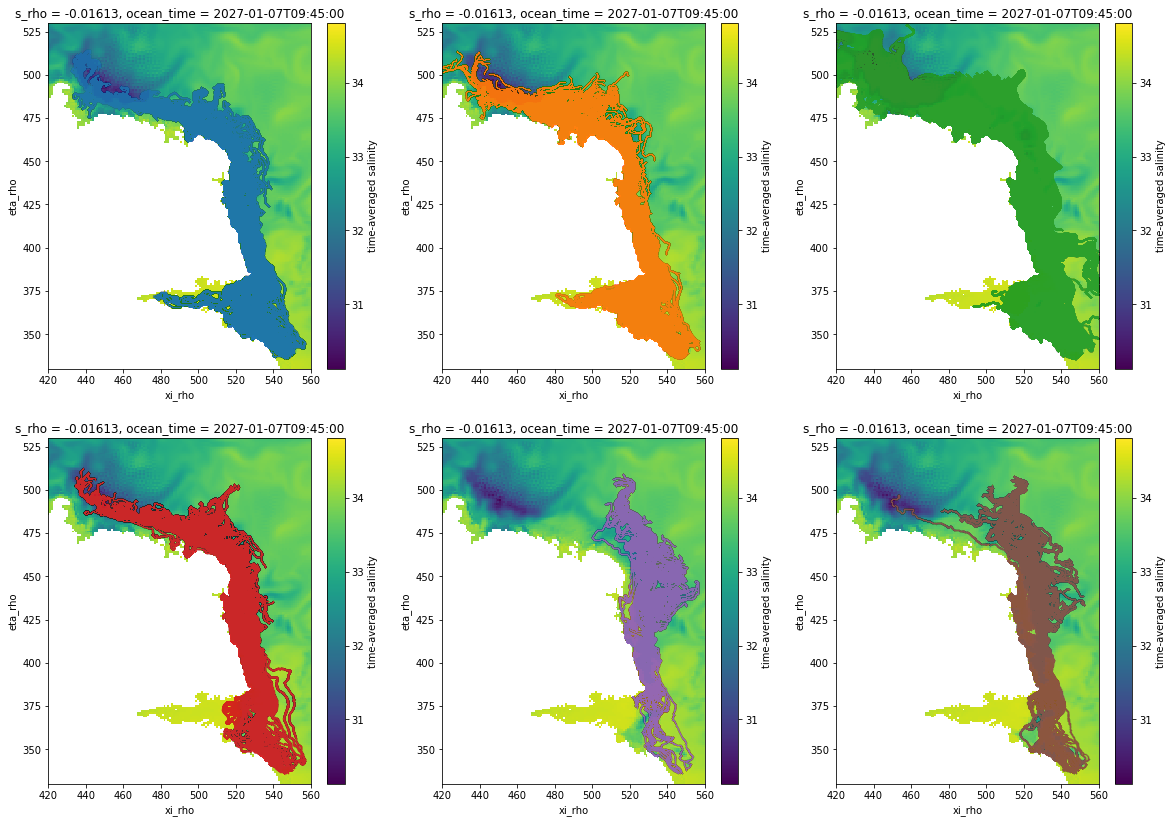

In [13]:
# # THESE ARE IN GRID POINTS not spherical
fig = plt.figure(figsize=(20,14))
fig.tight_layout(pad=10)
ax = fig.add_subplot(2, 3, 1)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group0x,group0y,marker='.',s=0.1,color='tab:blue',alpha=0.2)
ax = fig.add_subplot(2, 3, 2)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group1x,group1y,marker='.',s=0.1,color='tab:orange',alpha=0.2)

ax = fig.add_subplot(2, 3, 3)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group2x,group2y,marker='.',s=0.1,color='tab:green',alpha=0.2)
ax = fig.add_subplot(2, 3, 4)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group3x,group3y,marker='.',s=0.1,color='tab:red',alpha=0.2)
ax = fig.add_subplot(2, 3, 5)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group4x,group4y,marker='.',s=0.1,color='tab:purple',alpha=0.2)

ax = fig.add_subplot(2, 3, 6)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group5x,group5y,marker='.',s=0.1,color='tab:brown',alpha=0.2)

plt.savefig("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/dendrogram_kmeans.png", dpi=300)

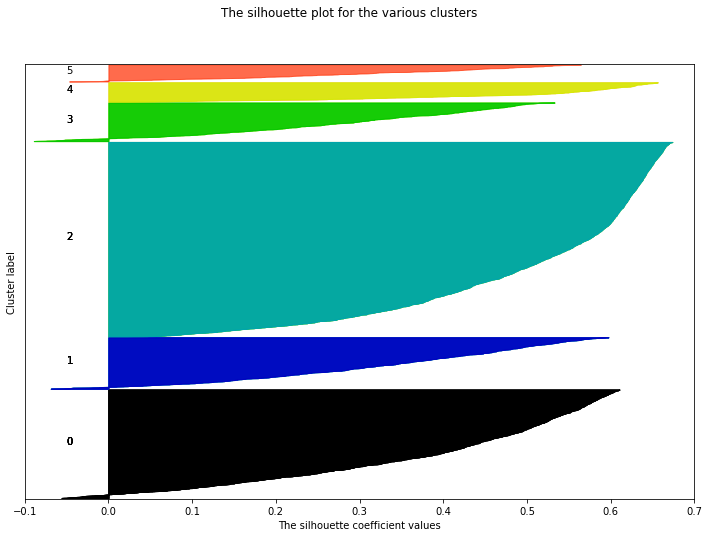

In [13]:
# show the outliers of the function
range_n_clusters = [0,1,2,3,4,5,6]
cluster_labels = assignment
# save outliers from each run
outliers = {}

plt.figure(figsize=(12,8))
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    plt.xlim([-0.1, 0.7])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        copyi = ith_cluster_silhouette_values.copy()
        
        # get the negative values
        #error_cluster=n_clusters-1
        #for idx in range(len(ith_cluster_silhouette_values)):
        #    if ith_cluster_silhouette_values[idx]<0:
        #        print(error_cluster,idx)

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    
    try:
        error_cluster=n_clusters-1
        #print(error_cluster,copyi)
        for idx in range(len(copyi)):
            if copyi[idx]<0:
                outliers[error_cluster]=idx
                #print(error_cluster,idx)
    except:
        a = 1

    plt.suptitle("The silhouette plot for the various clusters")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    #plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.1,0.2,0.3, 0.4,0.5, 0.6, 0.7])
    
plt.show()

In [14]:
# get the values for the outliers
state_out = {}
keys = (outliers.keys())
for key in keys:
    cluster = states[key]
    idx = outliers[key]
    stateout = cluster[idx]
    state_out[key] = stateout
    
keys2 = state_out.keys()
values = state_out.values()
for key,value in zip(keys2,values):
    print('The outlying state in cluster',key,'is',value)

The outlying state in cluster 0 is 5414
The outlying state in cluster 1 is 5351
The outlying state in cluster 3 is 5424
The outlying state in cluster 5 is 4630


### Distributions of values in these nodes

In [15]:
# make array of the groups
groups = np.array([group0,group1,group2,group3,group4,group5])

# add mean and stdev of group variables to dataframe
dist_ratio_mean = np.array([])
dist_ratio_stdev = np.array([])
mean_d_mean = np.array([])
mean_d_stdev = np.array([])
std_depth_mean = np.array([])
delta_salt_mean = np.array([])
delta_salt_stdev = np.array([])
delta_density_mean = np.array([])
delta_density_stdev = np.array([])

for group in groups:
    dist_ratio_mean = np.append(dist_ratio_mean,np.mean(df["net distance:total distance"][group].values))
    dist_ratio_stdev = np.append(dist_ratio_stdev,np.std(df["net distance:total distance"][group].values))
    mean_d_mean = np.append(mean_d_mean,np.mean(df["mean depth"][group].values))
    mean_d_stdev = np.append(mean_d_stdev,np.std(df["mean depth"][group].values))
    std_depth_mean = np.append(std_depth_mean,np.mean(df["std depth"][group].values))
    delta_salt_mean = np.append(delta_salt_mean,np.mean(df["d salt"][group].values))
    delta_salt_stdev = np.append(delta_salt_stdev,np.std(df["d salt"][group].values))
    delta_density_mean = np.append(delta_density_mean,np.mean(df["d density"][group].values))
    delta_density_stdev = np.append(delta_density_stdev,np.std(df["d density"][group].values))

/tmp/muramarg/14488476/ipykernel_1467020/1504767974.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups = np.array([group0,group1,group2,group3,group4,group5])


In [16]:
# first see the numbers of floats in each group
df1 = pd.DataFrame()
nmpts = np.array([])
nmpts = np.append(nmpts,len(group0))
nmpts = np.append(nmpts,len(group1))
nmpts = np.append(nmpts,len(group2))
nmpts = np.append(nmpts,len(group3))
nmpts = np.append(nmpts,len(group4))
nmpts = np.append(nmpts,len(group5))

# add this to the dataframe
df1["# of points"] = nmpts

df1["Distance ratio mean"] = dist_ratio_mean
df1["Distance ratio stdev"] = dist_ratio_stdev
df1["Mean depth mean"] = mean_d_mean
df1["Mean depth stdev"] = mean_d_stdev
df1["stdev depth"] = std_depth_mean
df1["delta salt mean"] = delta_salt_mean
df1["delta salt stdev"] = delta_salt_stdev
df1["delta density mean"] = delta_density_mean
df1["delta density stdev"] = delta_density_stdev
# df1

In [17]:
# # # # read the file and add the potential density values from pot_dens.txt
with open("/scratch/project_2000789/muramarg/SOM//meeting_1017/pot_dens.txt","r") as g:
    inp = g.read()
    inp = inp.replace(',', '\n')
    inp = inp.splitlines()
g.close()
lines = np.reshape(inp,(65717,5460))
pot_dens = lines.astype(float)

In [18]:
# find the average ending salinity, Temperature, density, and pressure for the groups
endS = np.array([])
endT = np.array([])
enddens = np.array([])
enddepth = np.array([])

for group in groups:
    endS = np.append(endS,np.mean(ds.variables["salt"].values[-1][group]))
    endT = np.append(endT,np.mean(ds.variables["temp"].values[-1][group]))
    enddens = np.append(enddens,np.mean(pot_dens[-1][group]))
    enddepth = np.append(enddepth,np.mean(ds.variables["depth"][-1][group]))

In [19]:
# the requirements for AABW are that >28.27 neutral density, 3500+ ft depth, Salinity 34.6-34.75, Temperature <0
df2 = pd.DataFrame()
df2["mean final s"] = endS
df2["mean final T"] = endT
df2["mean final rho"] = enddens
df2["mean final depth"] = enddepth*3.281
# df2

In [20]:
# select groups based on conditions
df4 = df2[df2['mean final depth'] <= -3500]
df5 = df4[df4["mean final s"] > 34.6]
df5 = df5[df5["mean final rho"] > 28.27]
df5

,mean final s,mean final T,mean final rho,mean final depth
1,34.600388,-0.469632,28.330337,-4500.156239
3,34.639599,-0.277609,28.730395,-7102.350902
4,34.648800,-0.290767,29.682924,-13634.336480
5,34.645893,-0.271533,29.238194,-10579.001354


### Select the points from these that may be AABW, recreate groups

In [23]:
# select the groups based on the results of the previous section
aabw_idx = np.concatenate((group1,group3,group4,group5))
aabw_idx.shape

(1606,)

In [24]:
# make new groups based on those that end as aabw
aabw_temp_last = ds.variables["temp"].values[:,aabw_idx][-1]
aabw_dep_last = ds.variables["depth"].values[:,aabw_idx][-1]
dens_last = pot_dens[:,aabw_idx][-1]

df_aa = pd.DataFrame()
df_aa["temp"] = aabw_temp_last
df_aa["depth"] = aabw_dep_last
df_aa["density"] = dens_last
df_aa['idx'] = aabw_idx
# df_aa

In [25]:
# select groups based on conditions
df_aa = df_aa[df_aa['temp'] <= -0]
df_aa = df_aa[df_aa['depth'] <= -1066.8] # meters
df_aa = df_aa[df_aa['density'] > 28.27]
df_aa

,temp,depth,density,idx
0,-0.371471,-1876.517090,28.592508,1
2,-0.324346,-1855.710083,28.584707,20
3,-0.352144,-1669.519775,28.493095,34
10,-0.372850,-1450.936035,28.383719,82
14,-0.296366,-1597.194214,28.459395,123
...,...,...,...,...
1601,-0.288971,-3517.321045,29.378146,5281
1602,-0.269788,-2592.360840,28.935779,5301
1603,-0.287411,-3855.935791,29.539198,5356
1604,-0.249169,-3407.947998,29.327270,5410


In [26]:
# idx column will be used to retrain dendrogram and kmeans
df_X = df.iloc[df_aa['idx']]
index_names = list(df_X.index)

### Write the output cells to a file to visualize in other document

In [27]:
# write these indexes to a text file
with open('recreate_groups.txt', 'w') as f:
    for idx in index_names:
        f.write(str(idx))
        f.write('\n')